In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [93]:
ss = pd.read_csv("sample_submission.csv")
train_df = pd.read_csv("train.csv/train.csv")
test_df = pd.read_csv("test.csv/test.csv")
fx = pd.read_excel('BAD_ADDRESS_FIX.xlsx')
macro = pd.read_csv("macro.csv")

#фиксим данные
fx.set_index('id',inplace=True)
train_df.set_index('id',inplace=True)
test_df.set_index('id',inplace=True)

train_df.update(fx)
test_df.update(fx)

print('Fix in train: ', train_df.index.intersection(fx.index).shape[0])
print('Fix in test : ', test_df.index.intersection(fx.index).shape[0])

train_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

#добавим фичи с временем
train_df['yearmonth'] = train_df['timestamp'].apply(lambda x: x[:4] + "-" + x[5:7])
train_df['year'] = train_df['timestamp'].apply(lambda x: x[:4])
train_df['month'] = train_df['timestamp'].apply(lambda x: x[5:7])

test_df['yearmonth'] = test_df['timestamp'].apply(lambda x: x[:4] + "-" + x[5:7])
test_df['year'] = test_df['timestamp'].apply(lambda x: x[:4])
test_df['month'] = test_df['timestamp'].apply(lambda x: x[5:7])

('Fix in train: ', 550)
('Fix in test : ', 149)


In [6]:
###################

In [124]:
from sklearn import model_selection, preprocessing
import xgboost as xgb

y_train = train_df["price_doc"]
x_train = train_df.drop(["id", "timestamp", "price_doc"], axis=1)
x_test = test_df.drop(["id", "timestamp"], axis=1)

for c in x_train.columns:
    if x_train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[c].values)) 
        x_train[c] = lbl.transform(list(x_train[c].values))
        
for c in x_test.columns:
    if x_test[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[c].values)) 
        x_test[c] = lbl.transform(list(x_test[c].values))

xgb_params = {
    'eta': 0.05,
    'max_depth': 4,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'rate_drop': 0.5,
    'silent': 1
}

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

[0]	train-rmse:8.21066e+06	test-rmse:8.21227e+06
[50]	train-rmse:2.73135e+06	test-rmse:2.97482e+06
[100]	train-rmse:2.39252e+06	test-rmse:2.76022e+06
[150]	train-rmse:2.26357e+06	test-rmse:2.71039e+06
[200]	train-rmse:2.17791e+06	test-rmse:2.68358e+06
[250]	train-rmse:2.10643e+06	test-rmse:2.66363e+06
[300]	train-rmse:2.04916e+06	test-rmse:2.65395e+06
[350]	train-rmse:1.99746e+06	test-rmse:2.6444e+06
[400]	train-rmse:1.95196e+06	test-rmse:2.6381e+06
[450]	train-rmse:1.91364e+06	test-rmse:2.63297e+06
[500]	train-rmse:1.87674e+06	test-rmse:2.62897e+06
[550]	train-rmse:1.84216e+06	test-rmse:2.62611e+06
[600]	train-rmse:1.80983e+06	test-rmse:2.62352e+06
CPU times: user 9min 53s, sys: 4.08 s, total: 9min 57s
Wall time: 2min 34s


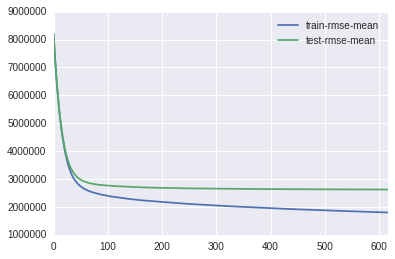

In [125]:
%%time
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

[0]	train-rmse:8.19915e+06	test-rmse:8.2079e+06
[50]	train-rmse:2.17083e+06	test-rmse:2.81916e+06
[100]	train-rmse:1.77633e+06	test-rmse:2.65607e+06
[150]	train-rmse:1.62295e+06	test-rmse:2.62976e+06
[200]	train-rmse:1.51053e+06	test-rmse:2.61992e+06
[250]	train-rmse:1.42239e+06	test-rmse:2.61621e+06
[300]	train-rmse:1.34291e+06	test-rmse:2.61504e+06
CPU times: user 8min 42s, sys: 824 ms, total: 8min 43s
Wall time: 2min 12s


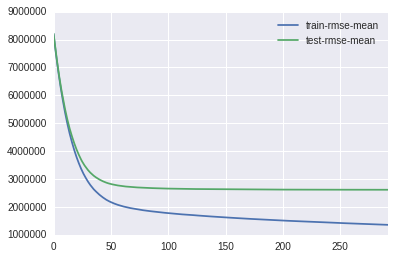

In [119]:
%%time
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [115]:
%%time
num_boost_rounds = 500#len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

CPU times: user 4min 56s, sys: 296 ms, total: 4min 56s
Wall time: 1min 16s


In [116]:
y_predict = model.predict(dtest)
id_test = test_df.id
output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})
output.head()

,id,price_doc
0,30474,5102918.0
1,30475,6684698.0
2,30476,5071336.0
3,30477,4449231.0
4,30478,3427465.5


In [117]:
output.to_csv('./naive_xgb_500.csv', index=False)